### Тестовое задание - анализ данных
В качестве тестового задания требуется  построить и валидировать модель для прогноза дефолта по данным в приложении: 
- Обучение модели на данных NBKI_train.csv
- Валидация модели на данных (NBKI_y_test.csv, NBKI_test.csv)
Целевая метрика gini

#### Формат сдачи:
- ноутбук с исследованием данных и обучением модели и формированием прогноза
- результат валидации модели на тестовых данных в разрезе признака [0]
- опционально: скрипт python который запускается из командной строки и на вход принимает параметр –csv файл с тестовыми данными и формирует предсказание вероятности дефолта 

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

from catboost import CatBoostClassifier, Pool


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# найтройки
# Убираем ограничение отображемых колонок
pd.set_option("display.max_columns", None)
# Устанавливаем тему по умолчанию
sb_dark = sns.dark_palette('skyblue', 8, reverse=True) # teal
sns.set(palette=sb_dark)

In [3]:
PATH = "./"
PATH_DATASETS = PATH + "datasets/"

In [4]:
train_nbki_df = pd.read_csv(PATH_DATASETS + "NBKI_train.csv", index_col="Unnamed: 0")
test_nbki_df = pd.read_csv(PATH_DATASETS + "NBKI_test.csv")
y_test_nbki_df = pd.read_csv(PATH_DATASETS + "NBKI_y_test.csv")
test_nbki_df = pd.merge(test_nbki_df, y_test_nbki_df, on="Unnamed: 0").set_index("Unnamed: 0").reset_index()#.drop(columns=["Unnamed: 0"])

train_nbki_df.shape, test_nbki_df.shape, y_test_nbki_df.shape

((30007, 134), (29993, 135), (29993, 2))

In [5]:
train_nbki_df.head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,default
48417,9,1,0,22,10,500000.0,75.0,75.0,3262,9.0,1.0,320500,3,3,5,7,8,11,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,1,10,24,17,7,12,4269811.0,177908,119009,3,2,3,3,4,5,5,0,0,1,1,1,2,423,1826,60,19,3262,19,0,0,0,0,0,0,0,0,430,333,5,3,0,0,0,61,40,2,1,0,0,0,0,0,13,1096,0.125000,0.00,0.011628,0.032787,1,0.0
109120,9,1,5,13,10,29983.0,22.0,22.0,2189,6.0,0.0,884426,1,3,7,17,26,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,4,11,7,4,5,491955.0,49195,37565,2,0,0,1,3,5,7,0,0,2,2,3,4,236,367,0,161,1459,247,0,0,0,0,0,0,0,0,147,123,3,2,0,0,0,53,46,0,0,0,0,0,1,0,3,123,0.181818,0.25,0.020408,0.000000,1,0.0
232425,9,1,0,15,10,730000.0,16.0,16.0,2863,8.0,1.0,208000,2,4,5,5,6,6,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,4,0,0,0,0,5,9,7,2,6,2272589.0,252509,171798,2,0,0,0,0,1,1,0,0,0,0,1,1,538,979,98,455,2860,1667,0,0,0,0,0,0,0,0,201,167,6,2,0,0,0,24,16,0,0,0,0,0,0,0,5,1826,0.222222,0.00,0.029851,0.000000,1,0.0
31393,7,1,0,8,10,0.0,68.0,68.0,6,0.0,0.0,0,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,498,0.000000,0.00,0.000000,0.000000,0,1.0
47064,1,1,0,22,10,901484.0,63.0,63.0,3708,10.0,0.0,1635500,8,15,15,17,23,27,3,3,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,2,6,8,0,0,0,15,0,0,0,2,7,23,20,3,20,1826926.0,83042,75247,3,1,2,2,4,8,11,0,1,2,4,7,9,283,993,31,23,3701,0,0,0,0,0,0,0,0,0,229,192,2,2,0,0,0,42,35,1,1,0,0,0,0,0,16,182,0.086957,0.00,0.008734,0.023810,1,0.0


<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Исходные данные</b>
<br/>
В исходных данных к тестовым данным также предоставлен таргет тестовых данных. Это позволяет использовать тестовые данные для оценки модели. Но есть риск "подгонки" модели именно под этот набор тестовых данных. Это надо учитывать.
</div>

## Первичный анализ

In [6]:
# Проверям типы данных
train_nbki_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30007 entries, 48417 to 19900
Data columns (total 134 columns):
 #    Column   Dtype  
---   ------   -----  
 0    0        int64  
 1    1        int64  
 2    2        int64  
 3    3        int64  
 4    4        int64  
 5    5        float64
 6    6        float64
 7    7        float64
 8    8        int64  
 9    9        float64
 10   10       float64
 11   11       int64  
 12   12       int64  
 13   13       int64  
 14   14       int64  
 15   15       int64  
 16   16       int64  
 17   17       int64  
 18   18       int64  
 19   19       int64  
 20   20       int64  
 21   21       int64  
 22   22       int64  
 23   23       int64  
 24   24       int64  
 25   25       int64  
 26   26       int64  
 27   27       int64  
 28   28       int64  
 29   29       int64  
 30   30       int64  
 31   31       int64  
 32   32       int64  
 33   33       int64  
 34   34       int64  
 35   35       int64  
 36   36    

In [7]:
# Проверям значения
describe_df = train_nbki_df.describe(include="all")
describe_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,default
count,30007.000000,30007.000000,30007.000000,30007.000000,30007.0,3.000700e+04,28819.000000,28918.000000,30007.000000,29938.000000,29809.000000,3.000700e+04,30007.000000,30007.00000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.00000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.0,30007.000000,30007.000000,30007.000000,30007.0,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,3.000700e+04,3.000700e+04,3.000700e+04,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000
mean,8.053654,1.023894,2.338121,16.326391,10.0,2.124157e+05,46.050036,45.760841,2531.282401,5.836562,0.555839,1.072456e+06,1.429167,2.57040,4.139967,7.074349,10.671843,12.816509,0.047955,0.071583,0.012430,0.017229,0.140534,0.278502,0.126737,0.204819,0.076982,0.125504,0.021728,0.035125,0.159063,0.294765,0.092378,0.150931,0.009864,0.012930,0.08378,0.160096,0.133369,0.243910,0.019829,0.032759,0.049855,0.111774,0.009065,0.018229,0.002299,0.003632,0.003666,0.005632,0.001566,0.002833,0.047989,0.091145,0.084747,0.153298,0.122638,0.196288,0.000033,0.000033,0.028960,0.059919,0.001000,0.002199,0.121672,0.241210,1.345453,0.078548,0.005165,0.0,2.365415,0.190489,0.014497,0.0,1.869131,4.043157,9.223348,6.919019,2.304329,5.339054,1.075811e+06,1.355677e+05,9.452587e+04,1.956443,0.246809,0.669144,1.247376,2.275002,3.598194,4.479388,0.192022,0.503749,0.944513,1.676042,2.720232,3.484787,355.230046,791.430966,142.204852,340.597127,2540.024428,501.046889,0.906389,0.450961,0.679475,0.813843,0.003433,0.000966,0.001700,0.002166,142.136435,99.340087,11.672077,1.940547,0.507448,0.362049,0.304796,26.276469,19.083814,1.485353,0.529277,0.105675,0.083047,0.076082,0.442330,28.588129,4.205585,4309.415936,0.201044,0.149875,0.065284,0.042948,0.934982,0.033326
std,1.461789,0.266673,1.822649,9.017349,0.0,7.026602e+05,23.971219,23.747816,1301.885619,3.782330,0.496881,4.750606e+06,3.141645,5.26519,8.238966,12.662466,16.805948,19.147212,0.403857,0.517643,0.169528,0.200819,0.571210,1.022925,0.466680,0.655454,0.323293,0.436509,0.177543,0.235276,0.845961,1.271483,0.776237,1.047328,0.204029,0.222163,0.71648,1.253628,0.987191,1.648934,0.320863,0.413432,0.343157,0.665594,0.101894,0.146390,0.056221,0.067965,0.068695,0.086795,0.047227,0.061843,0.258489,0.384917,0.375351,0.551815,0.515270,0.688743,0.005773,0.005773,0.273093,0.403786,0.031604,0.046848,0.5

In [8]:
# Проверям на мин/макс (также смотрим чтобы небыло -inf/inf) 
describe_df.loc["min"].min(), describe_df.loc["max"].max()

(-567.0, 606623042.0)

In [9]:
# Провереям кардинальность значений 
check_cardinality = train_nbki_df.apply(lambda x: x.nunique())
display(check_cardinality.describe())
print(f"80%: {check_cardinality.quantile(0.80)}")

count      134.000000
mean      1073.074627
std       4183.784234
min          1.000000
25%          9.000000
50%         25.000000
75%         78.000000
max      26525.000000
dtype: float64

80%: 91.4


In [10]:
threshold_cardinality = 20

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Кардинальность</b>
<ul>
    <li>Для всей выборки размера 30.000 объектов 75%  признаков имеют 80 уникальных значений, а 80% признаков имеют меньше 100 уникальных значений. </li>
    <li>Можем принять, что признаки у которых уникальных значений меньше 20 считаются категориальными. </li>
    <li>Данный порог уникальных значений надо учитывать для дальнейшего анализа</li>
</ul>
</div>

In [11]:
# определяем колонки таргетов и признаков
target_column = "default"
feature_columns = train_nbki_df.columns.drop(target_column)
categorical_columns = list(set(check_cardinality[check_cardinality <= threshold_cardinality].index) - set([target_column]))
numeric_columns = feature_columns.drop(categorical_columns)

assert len(feature_columns) == len(categorical_columns) + len(numeric_columns), "Ошибка в определении фичей"
assert len(train_nbki_df.columns) == len(feature_columns) + len([target_column]), "Ошибка в определении фичей"

len(feature_columns), len(categorical_columns), len(numeric_columns), len([target_column])

(133, 60, 73, 1)

### Проверка на дисбаланс классов

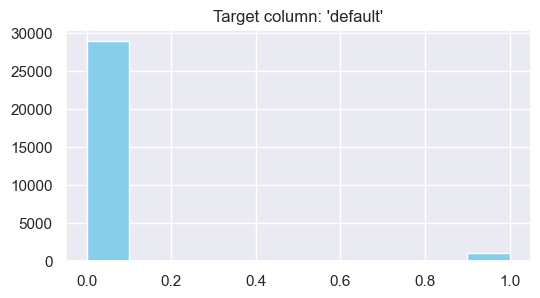

,default
0.0,29007
1.0,1000


In [12]:
# Проверяем дисбаланс классов
plt.figure(figsize=(6,3))
train_nbki_df["default"].hist()
plt.title(f"Target column: 'default'")
plt.show()
pd.DataFrame(train_nbki_df["default"].value_counts())

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Дисбаланс</b>
<br>
<ul>
<li>В данных присутствует явный дисбаланс данных: 1 к 29.
Это необходимо учесть перед обучением модели.</li>
</ul>
</div>

### Проверка на пропуски данных

In [13]:
# Смотрим в каких столбцах есть пропуски данных
print("NaNs in train")
nan_contains = train_nbki_df.isna().sum()
display(pd.DataFrame(nan_contains[nan_contains > 0]))
print("NaNs in test")
nan_contains = test_nbki_df.isna().sum()
display(pd.DataFrame(nan_contains[nan_contains > 0]))
# В обучающией и в тестовых пропуски в одних и тех же признаках

NaNs in train


,0
6,1188
7,1089
9,69
10,198


NaNs in test


,0
6,1054
7,967
9,68
10,184


In [14]:
# Проверяем, что пропуски данных это не особенность целевого таргета (банкротсва)
nan_contains = train_nbki_df[train_nbki_df[target_column] == 1].isna().sum()
pd.DataFrame(nan_contains[nan_contains > 0])

,0
6,29
7,22
10,3


In [15]:
train_nbki_df[["6", "7", "9", "10" ]].describe()

,6,7,9,10
count,28819.000000,28918.000000,29938.000000,29809.000000
mean,46.050036,45.760841,5.836562,0.555839
std,23.971219,23.747816,3.782330,0.496881
min,1.000000,1.000000,0.000000,0.000000
25%,24.000000,24.000000,2.000000,0.000000
50%,50.000000,50.000000,6.000000,1.000000
75%,66.000000,66.000000,9.000000,1.000000
max,99.000000,99.000000,13.000000,1.000000


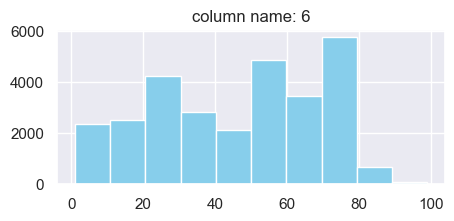

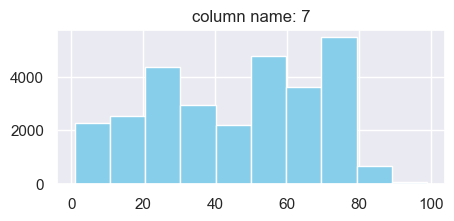

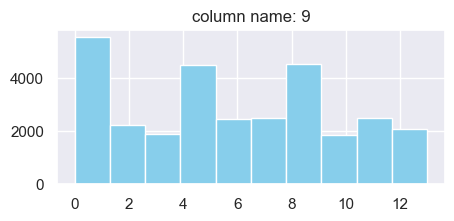

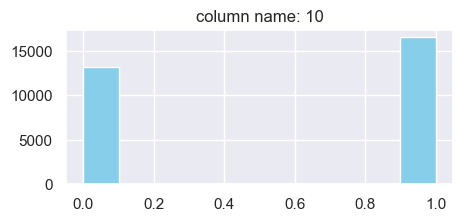

In [16]:
for c in ["6", "7", "9", "10" ]:
    plt.figure(figsize=(5,2))
    train_nbki_df[c].hist()
    plt.title(f"column name: {c}")
    plt.show()

In [17]:
def fillna_df(df):
    df["6"] = df["6"].fillna(df["6"].median())
    df["7"] = df["7"].fillna(df["7"].median())
    df["9"] = df["9"].fillna(df["9"].value_counts().sort_values(ascending=False).index[0])
    df["10"] = df["10"].fillna(df["10"].value_counts().sort_values(ascending=False).index[0])
    return df

In [18]:
train_nbki_df = fillna_df(train_nbki_df)
test_nbki_df = fillna_df(test_nbki_df)

In [19]:
# Проверяем, что не осталось значний NaN
nan_contains = train_nbki_df.isna().sum()
assert len(nan_contains[nan_contains > 0]) == 0, "Остались не учтенные NaN в обучающей выборке"
nan_contains = test_nbki_df.isna().sum()
assert len(nan_contains[nan_contains > 0]) == 0, "Остались не учтенные NaN в тестовой выборке"

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Пропуски в данных</b>
<br>
<ul>
    <li>Пропуски наблюдаются в колонках: 6,7,9,10</li>
    <li>В обучающией и в тестовых пропуски в одних и тех же признаках.</li>
    <li>Проверено, что пропуски данных - это не особенность именного целевого таргета (банкротсва), можно произовдить заполнение пропусков по упращенному пути</li>
    <li>Распределение значений для "6", "7" находится между 0 и 100. Для заполнения пропусков будет использовано медианное значение</li>
    <li>Распределение значений для признака "9" находится между 0 и 12. Для заполнение пропусков будет использовано самое популярное значение</li>
    <li>Значения признака "10" - либо 0 либо 1. Для заполнения пропусков будет использовано самое популярное значение</li>
</ul>
</div>

### Распределений значений в признаках

Распределение значений в обучающей выборке


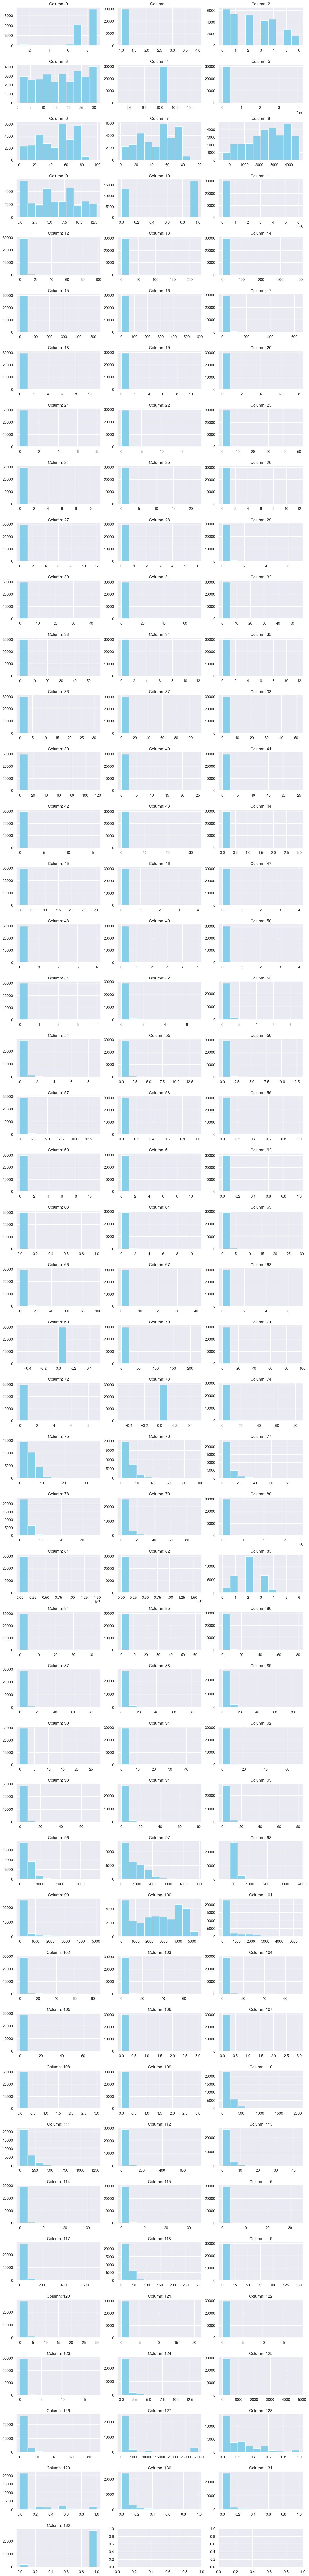

Wall time: 18.6 s


In [20]:
%%time
# Визуализация распределений значений в данных 
ncols = 3
nrows = len(feature_columns)//3 + 1
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 3*nrows))
plt.subplots_adjust(hspace=0.5)
print("Распределение значений в обучающей выборке")
for column_name, ax in zip(feature_columns, axs.ravel()):
    train_nbki_df[column_name].hist(ax=ax)
    ax.set_title(f"Column: {column_name}")
plt.show()

Распределение значений в тестовой выборке


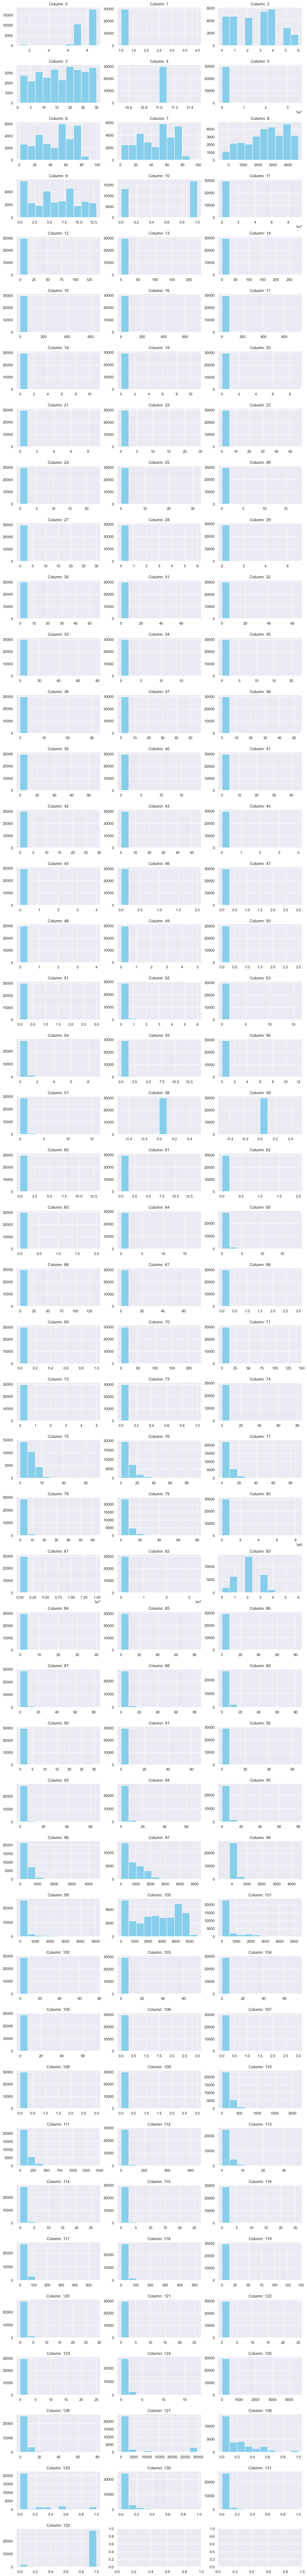

Wall time: 18.7 s


In [21]:
%%time
# Визуализация распределений значений в тестовых данных.
# !!!Тестовые данные трогать нельзя и по хорошему даже подсматривать за распределением не рекомендуется, но мы все же посмотрим =) 
ncols = 3
nrows = len(feature_columns)//3 + 1
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 3*nrows))
plt.subplots_adjust(hspace=0.5)
print("Распределение значений в тестовой выборке")
for column_name, ax in zip(feature_columns, axs.ravel()):
    test_nbki_df[column_name].hist(ax=ax)
    ax.set_title(f"Column: {column_name}")
plt.show()

In [22]:
# Выявляем константные признаки
constant_features = []

# Базовый способ выявления констант, просто если одно значение  - это константа
# for column in feature_columns:
#     if len(train_df[column].value_counts()) == 1:
#         constant_features.append(column)

# Продвинутый способ. За константу также принимаем те признаки у которых больше 99,9% значений в одном значении
for column in feature_columns:
    unique_labels, counts = np.unique(train_nbki_df[column].values, return_counts=True)
    proportions = counts / len(train_nbki_df[column].values)
    if max(proportions > 0.999) and len(proportions) <= 2:
        print(f"column: {column}, imbalance > 0.999, proportions: {len(proportions)}, ({proportions[:2]})")
        constant_features.append(column)
# Исключаем из списка фичей, те фичи у которых значения константые
feature_columns = list(set(feature_columns) - set(constant_features))
categorical_columns = list(set(categorical_columns) - set(constant_features))
numeric_columns = list(set(numeric_columns) - set(constant_features))
len(feature_columns), len(categorical_columns), len(numeric_columns)

column: 4, imbalance > 0.999, proportions: 1, ([1.])
column: 58, imbalance > 0.999, proportions: 2, ([9.99966674e-01 3.33255574e-05])
column: 59, imbalance > 0.999, proportions: 2, ([9.99966674e-01 3.33255574e-05])
column: 62, imbalance > 0.999, proportions: 2, ([0.99900023 0.00099977])
column: 69, imbalance > 0.999, proportions: 1, ([1.])
column: 73, imbalance > 0.999, proportions: 1, ([1.])


(127, 54, 73)

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Распределений значений</b>
<br>
<ol>
    <li> Наблюдаются значения близкие к константным, например признак "1", у которого (значение "1" встречается 29768 раз, а значение "4" встречается 239 раз). Такие признаки необходимо исключить. Если только эти редкие значения не дают явный информационный выигрыш, например признак есть ли судимость, может встречается только у 1 из 10000 человек, но это является очень явным признаком ненадежности челоека. Варианты действий:
        <ul>
            <li>Удалить такого признаки, которые близки константным значемниям</li>
            <li>Проверить корреляцию редких значений с искомым таргетом и тогда принять решение об удалении</li>
        </ul>
    </li>
    <br>
    <li>Наблюдается много признаков у которых основные значения находятся в одной области, но присутствуют аномальные значения (вероятно выбросы), из-за которых графики изображены в виде большого скопления значений в одном месте но ось абсцисс растянута, значит есть некоторое кол-во значений с аномальными значениями. Например признак "15". Варианты действий:
        <ul>
            <li>Можно оставить как есть, потому что для деревьев (планируется использовать бустинг) эти значения будут просто обработаны в рамках разделеяющих правил дереврьев. Также необходимо учитывать, что это могут быть не выбросы, а действительные просто такие данные.</li>
            <li>Можно обрезать значения. Для значений больше какого-то порога, указывать значение этого порога</li>
            <li>В случае использования линейных моделей (в том числе нейронных сетей) можно прологорифмировать эти признаки (предварительно решив что делать с нулевыми значениями), чтобы изменить масштаб и чтобы не возникали ненормальные веса из-за таких разбросов значений. В нашем же случае будет применятся бустинг (потому что он лучше работает с табличными данными, чем нейронки или линейные модели), поэтому можно не изменять масштаб данных</li>
        </ul>
    </li>
</ol>
<hr>
На <b>первом</b> этапе примем следующие решения:  
<ul>
    <li>Константные признаки - удалим те признаки которые явно являются константами, остальные будут отсеяны на этапе построения матрицы корреляции</li>
    <li>Признаки с "выбросами" - на первом этапе оставить как есть</li>
</ul>
В дальнейшем возможно сделать пересмотр способа обрабтки указанных признаков     
</div>



### Анализ значимости признаков

Анализ значимости признаков:
- корреляция
- p-value
- хи-квадрат (для категориальных признаков)

In [23]:
%%time
# Формирование матрицы корреляции
matrix_corr = train_nbki_df.corr()

Wall time: 1.35 s


Wall time: 409 ms


Text(0.5, 1.0, 'Матрица корреляции')

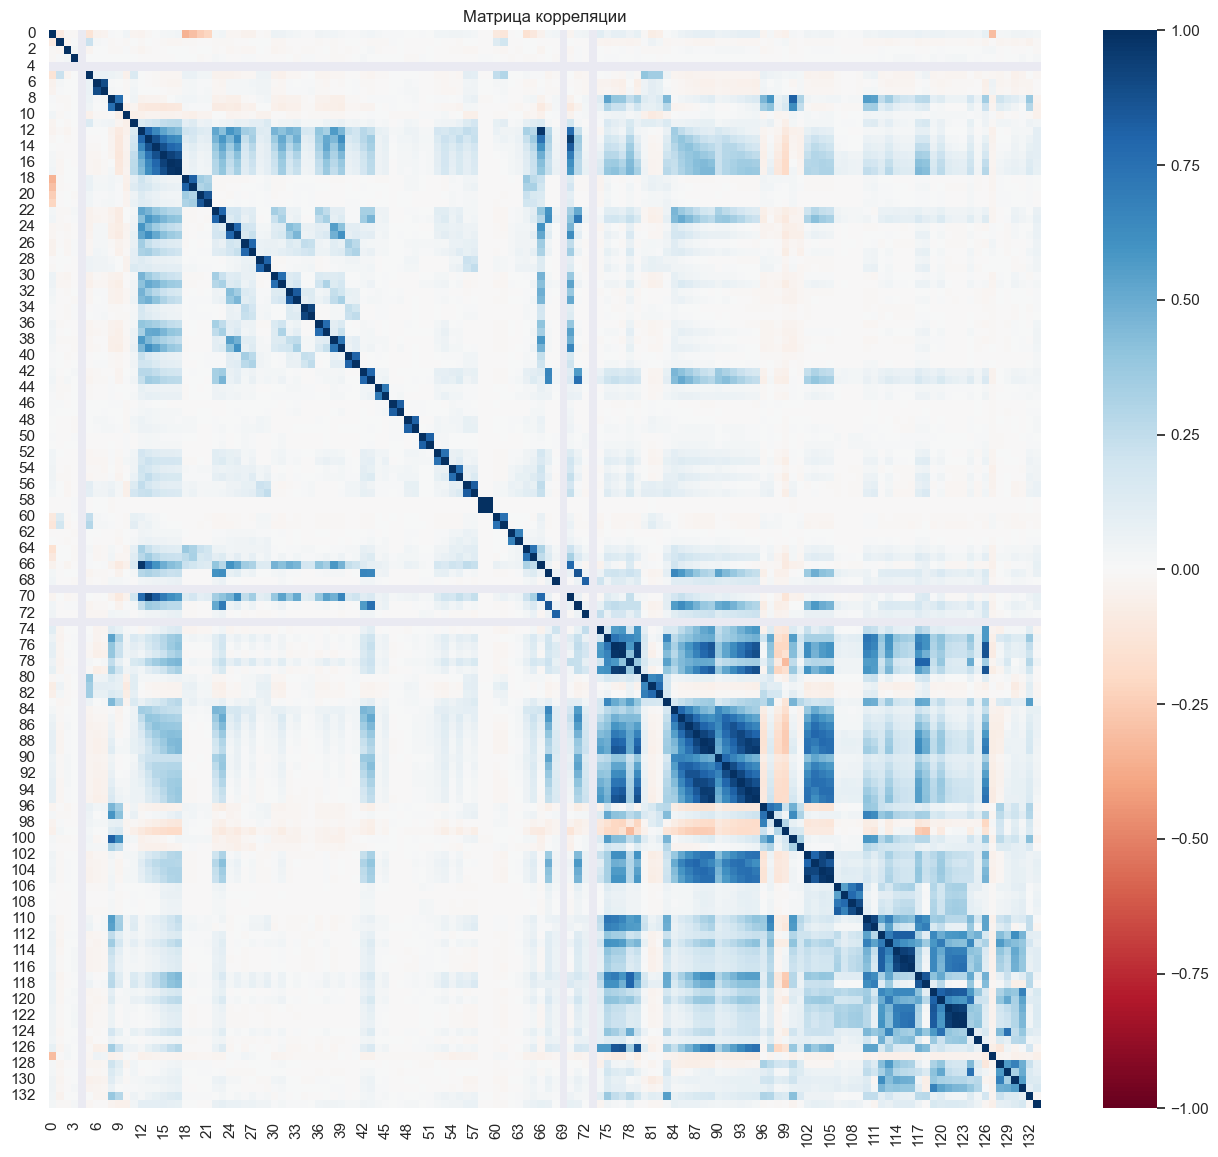

In [24]:
%%time
# Вывод матрицы корреляции
plt.figure(figsize=(16, 14))
heatmap = sns.heatmap(matrix_corr, vmin=-1, vmax=1, cmap='RdBu')
heatmap.set_title('Матрица корреляции');

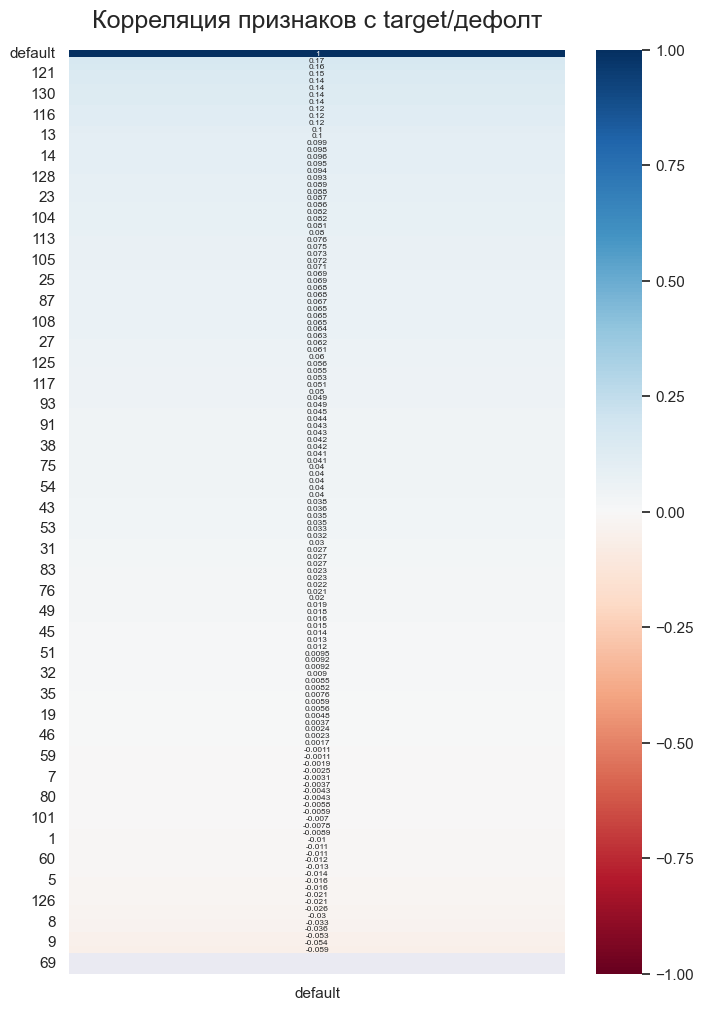

In [25]:
# Признаки коррелирующие с банкротством
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(matrix_corr[[target_column]].sort_values(by=target_column, ascending=False), vmin=-1, vmax=1, annot=True, cmap='RdBu', annot_kws={"fontsize":6})
heatmap.set_title('Корреляция признаков с target/дефолт', fontdict={'fontsize':18}, pad=16);

In [26]:
abs(matrix_corr[[target_column]]).sort_values(by=target_column, ascending=False)[:10]

,default
default,1.000000
131,0.165954
119,0.162577
121,0.146806
122,0.141112
123,0.139968
130,0.136896
120,0.135950
115,0.121643
116,0.121474


In [31]:
# Топ признаков влияющие на факт банкротства:
matrix_corr[matrix_corr[target_column].abs() > 0.14][[target_column]]

,default
119,0.162577
121,0.146806
122,0.141112
131,0.165954
default,1.000000


In [32]:
# Проверяем уровень значимости p-value и уровень корреляции с целевой функцией
high_p_value = []

for column in feature_columns:
    feat = train_nbki_df[column]
    target = train_nbki_df[target_column]
    res = stats.pearsonr(feat, target)
    corr, p_value = res
    if p_value > 0.05 and abs(corr) < 0.01:
        high_p_value.append(column)         
        print(f"column: {column}, p_value ({p_value}) > 0.05, corr ({abs(corr)}) < 0.01")

column: 20, p_value (0.3028886806094353) > 0.05, corr (0.005947701484055303) < 0.01
column: 19, p_value (0.40449646638628595) > 0.05, corr (0.004812505057389107) < 0.01
column: 21, p_value (0.31843867318832797) > 0.05, corr (0.005759579419412774) < 0.01
column: 46, p_value (0.6885959806384963) > 0.05, corr (0.0023136189975489305) < 0.01
column: 32, p_value (0.11903532792395347) > 0.05, corr (0.008999083628844249) < 0.01
column: 80, p_value (0.45527982115414284) > 0.05, corr (0.004310395040919614) < 0.01
column: 118, p_value (0.1766388803072786) > 0.05, corr (0.007800317856476106) < 0.01
column: 110, p_value (0.1542809639427783) > 0.05, corr (0.008224014319956173) < 0.01
column: 47, p_value (0.11102202397158478) > 0.05, corr (0.009199862764263964) < 0.01
column: 7, p_value (0.5901072590276186) > 0.05, corr (0.0031098331718028204) < 0.01
column: 72, p_value (0.6804368046323256) > 0.05, corr (0.0023777343760227184) < 0.01
column: 68, p_value (0.7748438718869806) > 0.05, corr (0.0016513549

In [29]:
%%time
from sklearn.feature_selection import chi2
chi2_res = chi2(train_nbki_df[categorical_columns], pd.DataFrame(target))
chi2_threshold = np.quantile(chi2_res, 0.5) # порог хи-квадрат будем рассчитывать по заданному квантилю
for i, cat_column in enumerate(categorical_columns):
    chi2_stat = chi2_res[0][i]
    p_value = chi2_res[1][i]
    if chi2_stat > chi2_threshold and p_value > 0.05:
        high_p_value.append(cat_column)
        print(f"column: {cat_column}, p_value ({p_value}) > 0.05, chi2_stat ({chi2_stat}) -> high value")

column: 20, p_value (0.11721405254970706) > 0.05, chi2_stat (2.4541574000211286) -> high value
column: 50, p_value (0.2439600991933647) > 0.05, chi2_stat (1.3575640516705798) -> high value
column: 47, p_value (0.07232295138355575) > 0.05, chi2_stat (3.2294958227419333) -> high value
column: 51, p_value (0.055612968947366) > 0.05, chi2_stat (3.663611324649832) -> high value
column: 19, p_value (0.10677237727176309) > 0.05, chi2_stat (2.601355230972631) -> high value
column: 21, p_value (0.12691228422328535) > 0.05, chi2_stat (2.329872348494016) -> high value
column: 2, p_value (0.06687333606883193) > 0.05, chi2_stat (3.358145524819537) -> high value
column: 18, p_value (0.23739622273827818) > 0.05, chi2_stat (1.3959894529783654) -> high value
Wall time: 953 ms


In [30]:
# Оценка Z-score
# В Z-score предполагается, что каждое наблюдение, для которого значение статистики больше 3 или меньше -3, является выбросом.
# Т.е. на сколько стандартных отклонений (сигм) значения признака меньше или больше генеральной совокупности (для нормального распределения).
z_score = np.abs(stats.zscore(train_nbki_df[feature_columns]))
train_nbki_df[feature_columns][(z_score<3).all(axis=1)].shape, train_nbki_df.shape
# Примерно половиина объектов имеет признаки у которых отклонение от генеральной выборки отличается на более чем 3 сигмы. 
# Мы не будем их исключать, потому что деревья (в частности бустинг) сам распределит такие выбросы по нужным веткам (если будут выбраны соответствующие решающие правила)
# Данную инфомрацию просто принимаем к сведению и при необходимости дальнейшем сделаем более детальный разбор для каждого признака

((14178, 127), (30007, 134))

In [31]:
# На данном этапе не производим преднамеренное исключение слабокоррелирующих признаков
# Исключаем из списка фичей, те фичи у которых значения константые
# feature_columns = list(set(feature_columns) - set(high_p_value))
# categorical_columns = list(set(categorical_columns) - set(high_p_value))
# numeric_columns = list(set(numeric_columns) - set(high_p_value))
# len(feature_columns), len(categorical_columns), len(numeric_columns)

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Значимость признаков</b>
<br>
<ul>
    <li>По матрице корреляции наблюдается ряд признаков сильно коррелирующих между собой. Данные признаки надо будет фильтровать на этапе построения модели и на этапе генерации новых признаков</li>    
    <li>Проверяем p-value и коэффициент корреляции Пирсона между каждым числовым признаком и целевой переменой. Чем ниже p-value, тем больше статистическая значимость рассматриваемых признаков. Значение p-value меньшее или равное 0,05 считается статистически значимым. Признаки с большим значением p-value (признак стат. не значим) и с маленькой корреляцией (связь признака с таргетом не обнаружена) стоит исключить из рассмотрения, но на данном этапе не производим исключений слабокоррелирующих признаков. В дальнейшем будет произведен дополнительный анализ.</li>
    <li>Для категориальных признаков также проверея стат-значимость через Хи-квадрат. В дальнешем для ужесточения отбора признаков можно повысить порог стат-значимости</li>    
    <li>Примерно половиина объектов имеет признаки у которых отклонение от генеральной выборки отличается на более чем 3 сигмы. Мы не будем их исключать, потому что деревья (в частности бустинг) сам распределит такие выбросы по нужным веткам (если будут выбраны соответствующие решающие правила). Данную инфомрацию просто принимаем к сведению и при необходимости дальнейшем сделаем более детальный разбор для каждого признака</li>    
</ul>


### Формироване train/val/test

Деление данных на train/val/test надо делать с учетом дисбаланса классов

In [33]:
train_df, val_df = train_test_split(train_nbki_df[feature_columns + [target_column]], test_size=0.2, shuffle=True, random_state=53, stratify=train_nbki_df[target_column]) 
val_df, test_df = train_test_split(val_df, test_size=0.5, shuffle=True, random_state=53, stratify=val_df[target_column]) 
test_true_df = test_nbki_df[feature_columns + [target_column]].copy()

In [34]:
# Учитывая, что в таргете сильный дисбаланс, тогда проверяем, что распределение val/train равно исходному
v_cnt_nbki_df = train_nbki_df[target_column].value_counts()
v_cnt_train = train_df[target_column].value_counts()
v_cnt_val = val_df[target_column].value_counts()
v_cnt_test = test_df[target_column].value_counts()
assert round(v_cnt_nbki_df[1]/v_cnt_nbki_df[0], 4) == round(v_cnt_train[1]/v_cnt_train[0], 4)
assert round(v_cnt_nbki_df[1]/v_cnt_nbki_df[0], 4) == round(v_cnt_val[1]/v_cnt_val[0], 4)
assert round(v_cnt_nbki_df[1]/v_cnt_nbki_df[0], 4) == round(v_cnt_test[1]/v_cnt_test[0], 4)

In [35]:
X_train = train_df[feature_columns]
y_train = train_df[target_column]
X_val = val_df[feature_columns]
y_val = val_df[target_column]
X_test = test_df[feature_columns]
y_test = test_df[target_column]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((24005, 127), (24005,), (3001, 127), (3001,), (3001, 127), (3001,))

## Построение модели

## Baseline Модель

In [36]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

In [37]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc

In [38]:
def calc_gini(auc_roc):
    gini = 2 * auc_roc - 1
    return gini

In [54]:
# baseline Модель
default_model = CatBoostClassifier(eval_metric = "AUC", early_stopping_rounds=200, random_state=53)
default_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

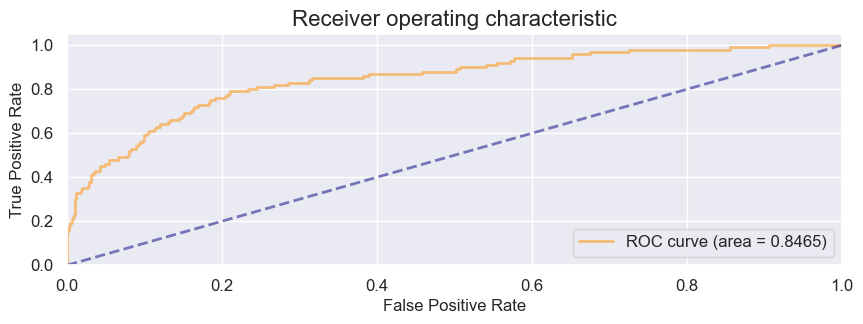

ROC-AUC: 0.8464701826956222, Gini: 0.6929403653912445


In [55]:
# Делаем предсказание на тестовых данных
y_pred_default = default_model.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_default)
print(f"ROC-AUC: {roc_auc}, Gini: {calc_gini(roc_auc)}")

In [56]:
# Переводим вероятностные предсказания в класс
threshold = 0.5
y_pred_default_class = (y_pred_default > threshold).astype(int) 

Распределение исходного таргета: 0.03332222592469177
Распределение предсказанного таргета: 0.005664778407197601


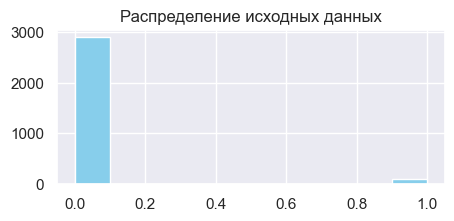

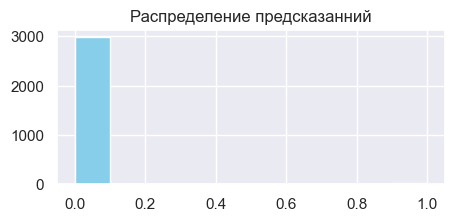

In [57]:
print(f"Распределение исходного таргета: {sum(y_test)/len(y_test)}")
print(f"Распределение предсказанного таргета: {sum(y_pred_default_class)/len(y_pred_default_class)}")

fig = plt.figure(figsize=(5,2))
pd.DataFrame(y_test).hist(ax=fig.gca())
plt.title("Распределение исходных данных")

fig = plt.figure(figsize=(5,2))
pd.DataFrame(y_pred_default_class).hist(ax=fig.gca())
plt.title("Распределение предсказанний")

plt.show()

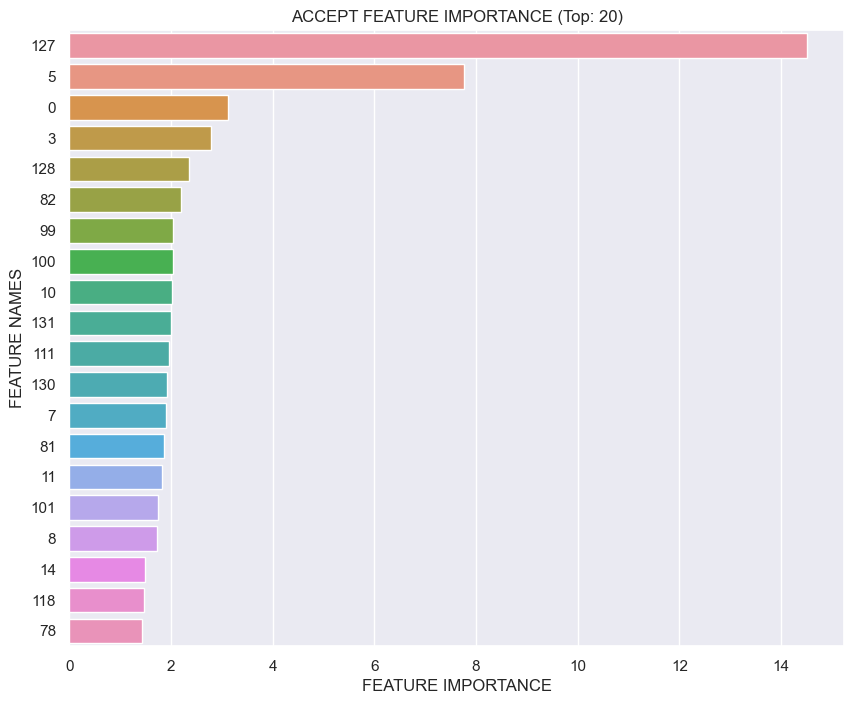

In [59]:
# Важность признаков
fi_df = plot_feature_importance(default_model.get_feature_importance(), X_test.columns, model_name='ACCEPT', top_n=20)  

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Промежуточный итог:</b>
<ul>
    <li>Выявлено сильное влияние параметра "127" на предсказания модели.</li>
    <li>Доля дефолтов в исходных данных: 0.0333, а в предсказанных: 0.0056. Это результат большого дисбаланса классов</li>
    <li>Следующий шаг борьба с дисбалансом классов</li>
</ul>
    
<b>Варианты улучшения:</b>
<ul>    
    <li>Борьба с дисбалансом</li>
    <li>Выбор порога threshold</li>
    <li>Feature engineering</li>
    <li>Подбор гиперпараметров</li>
    <li>Увеличение данных для обучения. Использование валидационных данных за счет кросс-валидации</li>
</ul>
   
<b>Результаты экспериментов:</b>
<table>
    <tr>
        <th>№</th>
        <th>Название</th>
        <th>Описание</th>
        <th>ROC-AUC на val</th>
        <th>ROC-AUC на test</th>
        <th>Gini на test</th>
        <th>Доля дефолтов в исходных данных</th>
        <th>Доля предсказанных дефолтов</th>
    </tr>
    <tr>
        <th>1</th>
        <th>Базовая модель</th>
        <th>Простая модель</th>
        <th>0.8794</th>
        <th>0.8464</th>
        <th>0.6929</th>
        <th>0.0333</th>
        <th>0.0056</th>
    </tr>
    
</table>
</div>

### Добавляем балансировку классов
Для учета дисбаланса классов используем compute_class_weight от sklearn  

In [60]:
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0.0: 0.5172376642964879, 1.0: 15.003125}

In [61]:
# Обучаем модель модель
default_model = CatBoostClassifier(eval_metric = "AUC", early_stopping_rounds=200, random_state=53, class_weights=class_weights)
default_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

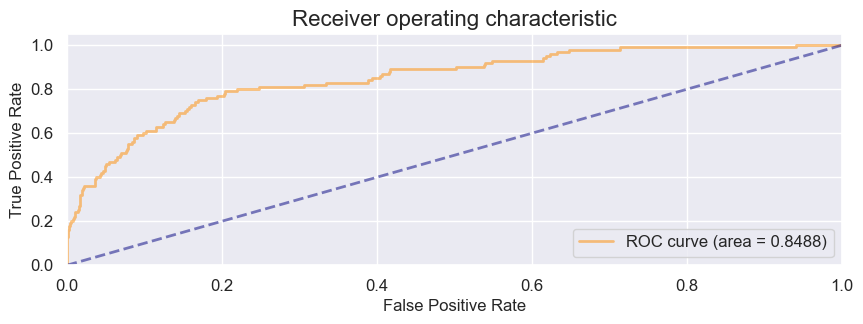

ROC-AUC: 0.8488279903481559, Gini: 0.6976559806963119


In [62]:
# Делаем предсказание на тестовых данных
y_pred_default = default_model.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_default)
print(f"ROC-AUC: {roc_auc}, Gini: {calc_gini(roc_auc)}")

In [63]:
# Переводим вероятностные предсказания в класс
threshold = 0.5
y_pred_default_class = (y_pred_default > threshold).astype(int) 

Распределение исходного таргета: 0.03332222592469177
Распределение предсказанного таргета: 0.10596467844051982


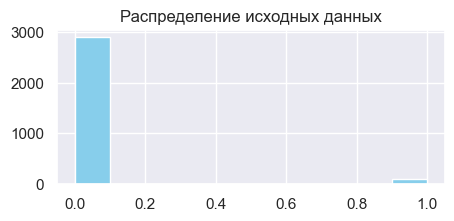

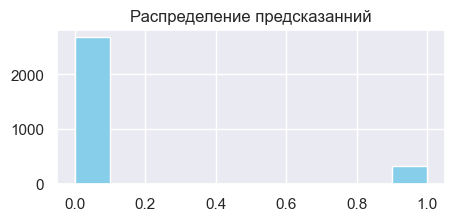

In [64]:
print(f"Распределение исходного таргета: {sum(y_test)/len(y_test)}")
print(f"Распределение предсказанного таргета: {sum(y_pred_default_class)/len(y_pred_default_class)}")

fig = plt.figure(figsize=(5,2))
pd.DataFrame(y_test).hist(ax=fig.gca())
plt.title("Распределение исходных данных")

fig = plt.figure(figsize=(5,2))
pd.DataFrame(y_pred_default_class).hist(ax=fig.gca())
plt.title("Распределение предсказанний")

plt.show()

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Промежуточный итог:</b>
<ul>
    <li>Балансировка улучшила метрику</li>
    <li>Теперь модель старается предсказать редкий класс, распределение предсказаний больше похоже на исходное распределение</li>
</ul>
   
<b>Результаты экспериментов:</b>
<table>
    <tr>
        <th>№</th>
        <th>Название</th>
        <th>Описание</th>
        <th>ROC-AUC на val</th>
        <th>ROC-AUC на test</th>
        <th>Gini на test</th>
        <th>Доля дефолтов в исходных данных</th>
        <th>Доля предсказанных дефолтов</th>
    </tr>
    <tr>
        <th>1</th>
        <th>Базовая модель</th>
        <th>Простая модель</th>
        <th>0.8794</th>
        <th>0.8464</th>
        <th>0.6929</th>
        <th>0.0333</th>
        <th>0.0056</th>
    </tr>
    <tr>
        <th>2</th>
        <th>Модель №1 + балансировка классов</th>
        <th>Учитываем в модели дисбаланс классов</th>
        <th>0.8742</th>
        <th>0.8488</th>
        <th>0.6976</th>
        <th>0.0333</th>
        <th>0.1059</th>
    </tr>    
    
</table>
</div>

### Выбор порога threshold

In [66]:
# Делаем предсказание модели (на тестовых данных) через predict_proba
y_pred_proba_default = default_model.predict_proba(X_test)

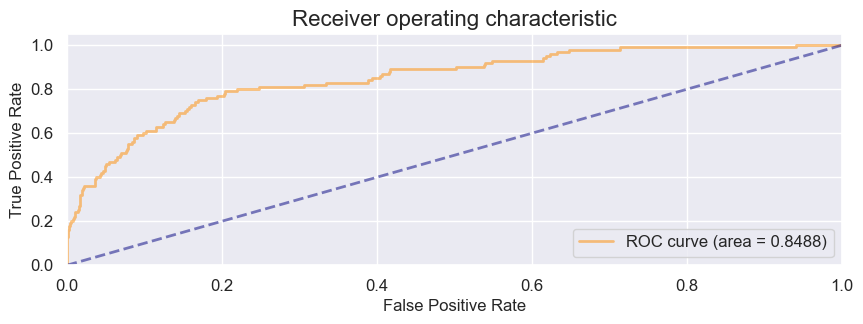

ROC-AUC: 0.8488279903481559, Gini: 0.6976559806963119


In [68]:
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_default)
print(f"ROC-AUC: {roc_auc}, Gini: {calc_gini(roc_auc)}")

In [69]:
# Определяем оптимальный порог как поиск максимального значения для разницы tpr - fpr
fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=y_pred_proba_default[:, 1])
best_thresh = thresholds[np.argmax(tpr - fpr)]
print(f"Оптимальный порог: {best_thresh}")

Оптимальный порог: 0.33018554682788337


In [71]:
# Переводим вероятностные предсказания в класс
y_pred_default_class = (y_pred_default > best_thresh).astype(int) 

In [72]:
print(f"Распределение исходного таргета: {sum(y_test)/len(y_test)}")
print(f"Распределение предсказанного таргета: {sum(y_pred_default_class)/len(y_pred_default_class)}")

Распределение исходного таргета: 0.03332222592469177
Распределение предсказанного таргета: 0.22359213595468178


<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Промежуточный итог:</b>
<ul>
    <li>Выбор порога (threshold) улучшил итоговую метрику AUC</li>
    <li>Теперь модель старается предсказать редкий класс, распределение предсказаний больше похоже на исходное распределение</li>
</ul>
   
<b>Результаты экспериментов:</b>
<table>
    <tr>
        <th>№</th>
        <th>Название</th>
        <th>Описание</th>
        <th>ROC-AUC на val</th>
        <th>ROC-AUC на test</th>
        <th>Gini на test</th>
        <th>Доля предсказанных дефолтов</th>
    </tr>
    <tr>
        <th>1</th>
        <th>Базовая модель</th>
        <th>Простая модель</th>
        <th>0.8794</th>
        <th>0.8464</th>
        <th>0.6929</th>
        <th>0.0056</th>
    </tr>
    <tr>
        <th>2</th>
        <th>Модель №1 + балансировка классов</th>
        <th>Учитываем в модели дисбаланс классов</th>
        <th>0.8742</th>
        <th>0.8488</th>
        <th>0.6976</th>
        <th>0.1059</th>
    </tr>    
    <tr>
        <th>3</th>
        <th>Модель №2 + оптимальный threshold</th>
        <th>Определяем оптимальный порог (threshold) для принятия решения о банкротстве. Модель не изменялась</th>
        <th>0.8742</th>
        <th>0.8488</th>
        <th>0.6976</th>
        <th>0.2235</th>
    </tr>        
</table>
</div>

### Выделяем категориральные признаки
На данный момент все признаки в модель подаются как числовые, это значит что если в данных есть категориальные признаки (которые закодираны 1, 2, 3, 4), то они используют по сути label-кодирование, когда категории дается порядковый номер. Это не лучший способ кодирования категориальных признаков, гораздо лучше OHE или target-кодирование. 
Данная гипотеза требует проверки и не факт, что покажет хорошие результаты.   
Можно самостоятельно сделать кодирование категориальных признаков, но в catboost под капотом как раз используется, что-то похожее на target-кодирование. Для catboost достаточно указать какие признаки являются категориальными, необходимое кодирование будет выполнено под капотом. Поэтому для быстрой проверки данного предположения воспользуемся как раз средствами catboost.      Для того чтобы числа перевести в категории достаточно перевести значения из числовых в текстовые и сообщить catboost список категориальных признаков  

In [73]:
threshold_cardinality = 20
categorical_columns = list(set(check_cardinality[(check_cardinality <= threshold_cardinality)].index) - set([target_column]))
categorical_columns = list(set(feature_columns)&set(categorical_columns))
print(f"Кол-во признаков попадающих под тип категориальный: {len(categorical_columns)}")

Кол-во признаков попадающих под тип категориальный: 54


In [74]:
X_train_category = X_train.copy()
X_val_category = X_val.copy()
X_test_category = X_test.copy()

X_train_category[categorical_columns] = X_train_category[categorical_columns].astype(str)
X_val_category[categorical_columns] = X_val_category[categorical_columns].astype(str)
X_test_category[categorical_columns] = X_test_category[categorical_columns].astype(str)

In [75]:
# Обучаем модель модель
default_model = CatBoostClassifier(eval_metric = "AUC", early_stopping_rounds=200, random_state=53, class_weights=class_weights, cat_features=categorical_columns)
default_model.fit(X_train_category, y_train, eval_set=(X_val_category, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Оптимальный порог: 0.3261619368609995


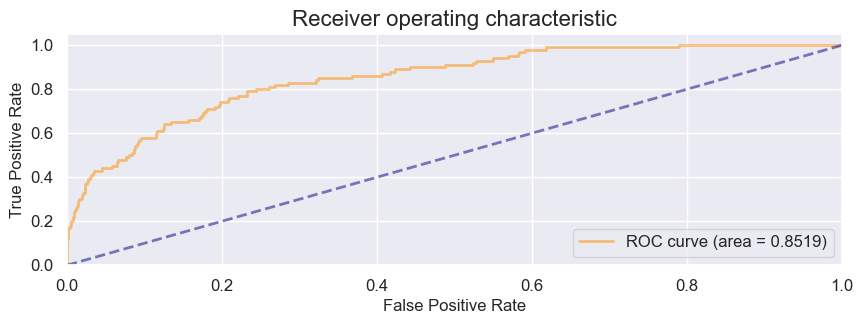

ROC-AUC: 0.8518855567045847, Gini: 0.7037711134091693
Распределение исходного таргета: 0.03332222592469177
Распределение предсказанного таргета: 0.25091636121292904


In [78]:
# Делаем предсказание на тестовых данных
y_pred_default = default_model.predict_proba(X_test_category)[:,1]

# Определяем оптимальный порог как поиск максимального значения для разницы tpr - fpr
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_default)
best_thresh = thresholds[np.argmax(tpr - fpr)]
print(f"Оптимальный порог: {best_thresh}")
# Формируем итоговое предсказание с учетом выбранного порога
y_pred_default_class = (y_pred_default > best_thresh).astype(int) 

# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_default)
print(f"ROC-AUC: {roc_auc}, Gini: {calc_gini(roc_auc)}")

print(f"Распределение исходного таргета: {sum(y_test)/len(y_test)}")
print(f"Распределение предсказанного таргета: {sum(y_pred_default_class)/len(y_pred_default_class)}")

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Промежуточный итог:</b>
<ul>
<li>Гипотеза: если в данных есть категориальные признаки (которые закодираны 1, 2, 3, 4), то они по сути предсталены в виде label-кодирования (когда категории дается порядковый номер). Это не лучший способ кодирования категориальных признаков, гораздо лучше OHE или target-кодирование.</li>
<li>Выделение ряда признаки в категориральный дало прирост ROC-AUC c 0.8488 до 0.8518. Можно считать, что гипотеза подтвердилась. </li>
<li>По факту признаки с малым кол-ом уникальных значений переведены в тип категориальные</li>
</ul>
   
    
<b>Результаты экспериментов:</b>
<table>
    <tr>
        <th>№</th>
        <th>Название</th>
        <th>Описание</th>
        <th>ROC-AUC на val</th>
        <th>ROC-AUC на test</th>
        <th>Gini на test</th>
        <th>Доля предсказанных дефолтов</th>
    </tr>
    <tr>
        <th>1</th>
        <th>Базовая модель</th>
        <th>Простая модель</th>
        <th>0.8794</th>
        <th>0.8464</th>
        <th>0.6929</th>
        <th>0.0056</th>
    </tr>
    <tr>
        <th>2</th>
        <th>Модель №1 + балансировка классов</th>
        <th>Учитываем в модели дисбаланс классов</th>
        <th>0.8742</th>
        <th>0.8488</th>
        <th>0.6976</th>
        <th>0.1059</th>
    </tr>    
    <tr>
        <th>3</th>
        <th>Модель №2 + оптимальный threshold</th>
        <th>Определяем оптимальный порог (threshold) для принятия решения о банкротстве. Модель не изменялась</th>
        <th>0.8742</th>
        <th>0.8488</th>
        <th>0.6976</th>
        <th>0.2235</th>
    </tr>               
    <tr>
        <th>4</th>
        <th>Модель №3 + выделение категориральных признаков</th>
        <th>Признаки с малым кол-ом уникальных значений переведены в тип категориальные</th>
        <th>0.8814</th>
        <th>0.8518</th>
        <th>0.7037</th>
        <th>0.2509</th>
    </tr>        
</table>
</div>

### Генерация новых признаков (Feature engineering)

Генерация признаков планируется по следующему плану:  
- Выбор топ N признаков которые имеют наибольшее влияение на модель - feature importance (используется предыдуще построенная модель)  
- Выбор топ N признаков имеющих наибольшую корреляцию с таргетом  
- Генерация отношений и произведений между выбраными признаками   
- Обучение и оценка модели с новыми признаками  

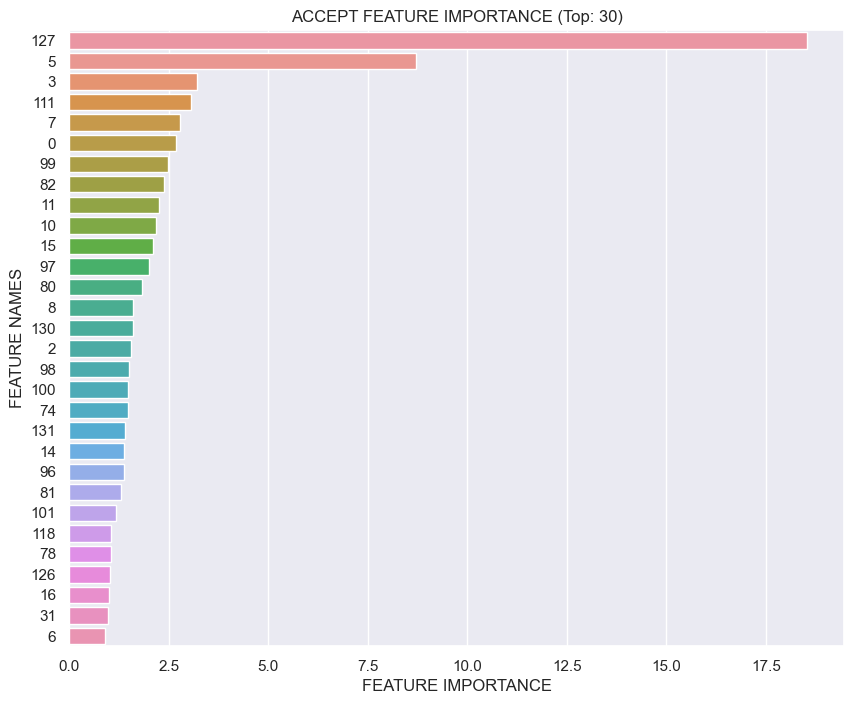

In [79]:
# Посмотрим на Топ 30 признаков, которые имеют влияние на модель
fi_df = plot_feature_importance(default_model.get_feature_importance(), X_test.columns, model_name='ACCEPT', top_n=30)  

In [80]:
train_nbki_df_generated = train_nbki_df[feature_columns + [target_column]].copy()
train_nbki_df_generated.shape

(30007, 128)

In [81]:
%%time
# Формируем матрицу корреляции
corr_matrix = train_nbki_df_generated.corr()
corr_matrix.shape

Wall time: 1.23 s


(128, 128)

In [82]:
%%time
n = 10
# Берем N признаков с наибольшей корреляцией с таргетом
base_features = set(abs(corr_matrix[target_column].drop([target_column], axis=0)).sort_values(ascending=False)[:n].index)
# Берем N признаков с наиболее важных для модели и объединяем с лучшими скоррелированными 
base_features |= set(fi_df.sort_values(by=["feature_importance"], ascending=False)[:n]["feature_names"].values)
base_features = base_features - set(categorical_columns)
base_features = list(base_features)
print(f"base_features: {len(base_features)}")


e = 1e-3 # добавляем минимальное значение, чтобы уйти от деления на ноль и появления бесконечностей
# Сгенерируем новые признаки, которые будут представлять: отношение одного к другому и произведение двух признаков
for i in range(len(base_features)):
    base_f_1 = base_features[i]
    for j in range(i+1, len(base_features)):
        base_f_2 = base_features[j]
        train_nbki_df_generated[f"new_rlt_{base_f_1}_{base_f_2}"] = (train_nbki_df_generated[base_f_1] + e)/(train_nbki_df_generated[base_f_2] + e)
        train_nbki_df_generated[f"new_mltp_{base_f_1}_{base_f_2}"] = train_nbki_df_generated[base_f_1]*train_nbki_df_generated[base_f_2]
train_nbki_df_generated.shape

base_features: 15
Wall time: 192 ms


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(30007, 338)

In [83]:
gen_feature_columns = list(train_nbki_df_generated.columns.drop([target_column]))
len(gen_feature_columns)

337

In [84]:
train_df, val_df = train_test_split(train_nbki_df_generated[gen_feature_columns + [target_column]], test_size=0.2, shuffle=True, random_state=53, stratify=train_nbki_df_generated[target_column]) 
val_df, test_df = train_test_split(val_df, test_size=0.5, shuffle=True, random_state=53, stratify=val_df[target_column]) 

X_train = train_df[gen_feature_columns]
y_train = train_df[target_column]
X_val = val_df[gen_feature_columns]
y_val = val_df[target_column]
X_test = test_df[gen_feature_columns]
y_test = test_df[target_column]

In [85]:
X_train_category = X_train.copy()
X_val_category = X_val.copy()
X_test_category = X_test.copy()

X_train_category[categorical_columns] = X_train_category[categorical_columns].astype(str)
X_val_category[categorical_columns] = X_val_category[categorical_columns].astype(str)
X_test_category[categorical_columns] = X_test_category[categorical_columns].astype(str)

In [86]:
X_train_category.shape

(24005, 337)

In [87]:
# Обучаем модель модель
default_model = CatBoostClassifier(eval_metric = "AUC", early_stopping_rounds=200, random_state=53, class_weights=class_weights, cat_features=categorical_columns)
default_model.fit(X_train_category, y_train, eval_set=(X_val_category, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Оптимальный порог: 0.352633456530546


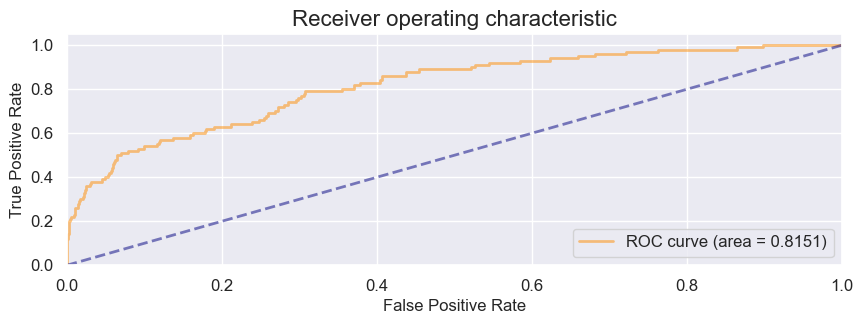

ROC-AUC: 0.8151223715960014, Gini: 0.6302447431920029
Распределение исходного таргета: 0.03332222592469177
Распределение предсказанного таргета: 0.32255914695101634


In [88]:
# Делаем предсказание на тестовых данных
y_pred_default = default_model.predict_proba(X_test_category)[:,1]

# Определяем оптимальный порог как поиск максимального значения для разницы tpr - fpr
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_default)
best_thresh = thresholds[np.argmax(tpr - fpr)]
print(f"Оптимальный порог: {best_thresh}")
# Формируем итоговое предсказание с учетом выбранного порога
y_pred_default_class = (y_pred_default > best_thresh).astype(int) 

# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_default)
print(f"ROC-AUC: {roc_auc}, Gini: {calc_gini(roc_auc)}")

print(f"Распределение исходного таргета: {sum(y_test)/len(y_test)}")
print(f"Распределение предсказанного таргета: {sum(y_pred_default_class)/len(y_pred_default_class)}")

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Промежуточный итог:</b>
<ul>
<li>Когда известно описание и природа признаков, тогда к генерации признаков можно подойти осознано, если о признаках ничего не известно, как в нашем случае, тогда можно рассмотреть следующую генерацию: расчет отношения и произведения двух признаков, возведение в степень и т.д. </li>
<li>Выбраны топ N признаков которые имеют наибольшее влияение на модель - feature importance и топ N признаков имеющих наибольшую корреляцию с таргетом. Произведена генерация отношений и произведений между выбраными признаками. </li>
<li>Оценка модели, обученной на сгенерированных признаков показала хуже скор, чем без сгенерированных признаков.</li>
<li>Генерация признаков в данном подходе не показала прирост к скору. В качестве развития возможно рассмотреть генерации по каждому признаку и прогон новых признаков через модель частями, чтобы не сильно увеличивать признаковое пространство</li>
</ul>
   
    
<b>Результаты экспериментов:</b>
<table>
    <tr>
        <th>№</th>
        <th>Название</th>
        <th>Описание</th>
        <th>ROC-AUC на val</th>
        <th>ROC-AUC на test</th>
        <th>Gini на test</th>
        <th>Доля предсказанных дефолтов</th>
    </tr>
    <tr>
        <th>1</th>
        <th>Базовая модель</th>
        <th>Простая модель</th>
        <th>0.8794</th>
        <th>0.8464</th>
        <th>0.6929</th>
        <th>0.0056</th>
    </tr>
    <tr>
        <th>2</th>
        <th>Модель №1 + балансировка классов</th>
        <th>Учитываем в модели дисбаланс классов</th>
        <th>0.8742</th>
        <th>0.8488</th>
        <th>0.6976</th>
        <th>0.1059</th>
    </tr>    
    <tr>
        <th>3</th>
        <th>Модель №2 + оптимальный threshold</th>
        <th>Определяем оптимальный порог (threshold) для принятия решения о банкротстве. Модель не изменялась</th>
        <th>0.8742</th>
        <th>0.8488</th>
        <th>0.6976</th>
        <th>0.2235</th>
    </tr>               
    <tr>
        <th>4</th>
        <th>Модель №3 + выделение категориральных признаков</th>
        <th>Признаки с малым кол-ом уникальных значений переведены в тип категориальные</th>
        <th>0.8814</th>
        <th>0.8518</th>
        <th>0.7037</th>
        <th>0.2509</th>
    </tr>  
    <tr>
        <th>5</th>
        <th>Модель №4 + генерация признаков</th>
        <th>Генерация произведений и отношений между выбраным Топ признаков</th>
        <th>0.8646</th>
        <th>0.8151</th>
        <th>0.6302</th>
        <th>0.3225</th>
    </tr>      
</table>
</div>

### Исключение признаков не влияющих на таргет
Идея такая:
- Строим корреляцию для всех признаков
- Убираем признаки которые сильно кореллируют с другими. Убираем признаки которые очень слабо кореллируют с целевым таргетом

In [89]:
%%time
# Формирование матрицы корреляции
matrix_corr = train_nbki_df[feature_columns + [target_column]].corr()
matrix_corr.shape

Wall time: 1.22 s


(128, 128)

In [103]:
# Оставляем признакми у которых есть корреляция с целевой переменой (таргетом)
limit_corr_level = 0.01
target_corr = abs(matrix_corr[target_column])
features_target_corr = list(set(target_corr[target_corr > limit_corr_level].index) - set([target_column]))
print(f"Выбрано {len(features_target_corr)} признаков")

Выбрано 103 признаков


In [104]:
# Убирем признакми с высоким уровнем корреляции между другими признаками
limit_corr_level = 0.95
select_features = []
skip_features = set([])

for feat in features_target_corr:
    if feat in skip_features:
        continue
    select_features.append(feat)
    skip_features |= set(matrix_corr[abs(matrix_corr[feat]) > limit_corr_level][feat].index)
print(f"Выбрано {len(select_features)} признаков")

Выбрано 94 признаков


In [105]:
# Определяем список категориальных признаков из выбранных 
select_categorical_columns = list(set(categorical_columns)&set(select_features)) 
print(f"Кол-во категориальных признаков ({len(select_categorical_columns)}) из выбранных ({len(select_features)}) признаков")

Кол-во категориальных признаков (39) из выбранных (94) признаков


In [106]:
X_train_category = X_train[select_features].copy()
X_val_category = X_val[select_features].copy()
X_test_category = X_test[select_features].copy()

X_train_category[select_categorical_columns] = X_train_category[select_categorical_columns].astype(str)
X_val_category[select_categorical_columns] = X_val_category[select_categorical_columns].astype(str)
X_test_category[select_categorical_columns] = X_test_category[select_categorical_columns].astype(str)

In [94]:
# Обучаем модель модель
default_model = CatBoostClassifier(eval_metric = "AUC", early_stopping_rounds=200, random_state=53, class_weights=class_weights, cat_features=select_categorical_columns)
default_model.fit(X_train_category, y_train, eval_set=(X_val_category, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Оптимальный порог: 0.23146345632993565


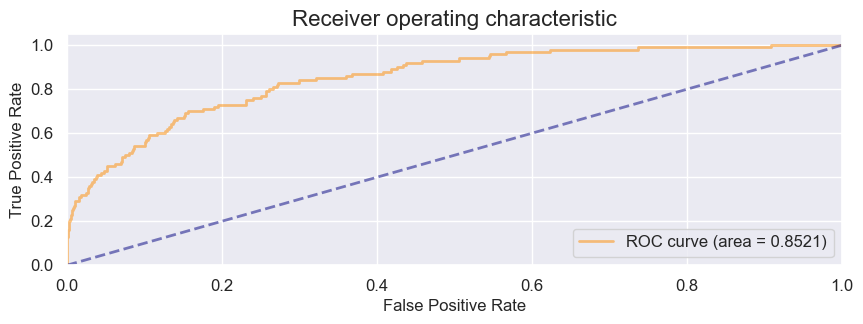

ROC-AUC: 0.8520751465012065, Gini: 0.704150293002413
Распределение исходного таргета: 0.03332222592469177
Распределение предсказанного таргета: 0.29090303232255915


In [95]:
# Делаем предсказание на тестовых данных
y_pred_default = default_model.predict_proba(X_test_category)[:,1]

# Определяем оптимальный порог как поиск максимального значения для разницы tpr - fpr
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_default)
best_thresh = thresholds[np.argmax(tpr - fpr)]
print(f"Оптимальный порог: {best_thresh}")
# Формируем итоговое предсказание с учетом выбранного порога
y_pred_default_class = (y_pred_default > best_thresh).astype(int) 

# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_default)
print(f"ROC-AUC: {roc_auc}, Gini: {calc_gini(roc_auc)}")

print(f"Распределение исходного таргета: {sum(y_test)/len(y_test)}")
print(f"Распределение предсказанного таргета: {sum(y_pred_default_class)/len(y_pred_default_class)}")

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Промежуточный итог:</b>
<ul>
<li>Убраны признаки которые сильно кореллируют с другими признаками (>0.95), и убраны признаки которые очень слабо кореллируют с целевым таргетом (<= 0.01)</li>
<li>Чистка признаков показала небольшой прирост к итоговому скору на тестовых данных. Также модель дольше не переобучается и на валидации показала скор выше</li>
</ul>
   
    
<b>Результаты экспериментов:</b>
<table>
    <tr>
        <th>№</th>
        <th>Название</th>
        <th>Описание</th>
        <th>ROC-AUC на val</th>
        <th>ROC-AUC на test</th>
        <th>Gini на test</th>
        <th>Доля предсказанных дефолтов</th>
    </tr>
    <tr>
        <th>1</th>
        <th>Базовая модель</th>
        <th>Простая модель</th>
        <th>0.8794</th>
        <th>0.8464</th>
        <th>0.6929</th>
        <th>0.0056</th>
    </tr>
    <tr>
        <th>2</th>
        <th>Модель №1 + балансировка классов</th>
        <th>Учитываем в модели дисбаланс классов</th>
        <th>0.8742</th>
        <th>0.8488</th>
        <th>0.6976</th>
        <th>0.1059</th>
    </tr>    
    <tr>
        <th>3</th>
        <th>Модель №2 + оптимальный threshold</th>
        <th>Определяем оптимальный порог (threshold) для принятия решения о банкротстве. Модель не изменялась</th>
        <th>0.8742</th>
        <th>0.8488</th>
        <th>0.6976</th>
        <th>0.2235</th>
    </tr>               
    <tr>
        <th>4</th>
        <th>Модель №3 + выделение категориральных признаков</th>
        <th>Признаки с малым кол-ом уникальных значений переведены в тип категориальные</th>
        <th>0.8814</th>
        <th>0.8518</th>
        <th>0.7037</th>
        <th>0.2509</th>
    </tr>  
    <tr>
        <th>5</th>
        <th>Модель №4 + генерация признаков</th>
        <th>Генерация произведений и отношений между выбраным Топ признаков</th>
        <th>0.8646</th>
        <th>0.8151</th>
        <th>0.6302</th>
        <th>0.3225</th>
    </tr>       
    <tr>
        <th>6</th>
        <th>Модель №4 + чистка признаков</th>
        <th>Исключены признаки слабо влияющие на таргет и признаки которые исльно коррелируют между собой</th>
        <th>0.8930</th>
        <th>0.8520</th>
        <th>0.7041</th>
        <th>0.2909</th>
    </tr>      
</table>
<br/>
<i>Лучшее качество показала Модель №6, которая включает: балансировку классов + выбор threshold + выделение категориральных признаков + генерацию и чистку признаков </i>
</div>

### Подбор гипперпараметров

In [96]:
# Смотрим текущие значения параметров модели
default_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBor

In [101]:
%%time
parameters = {'l2_leaf_reg': [2, 3, 4],
              'depth': [4, 6, 8],
              'learning_rate' : [0.01, 0.04, 0.07],
              }
grid_search_model = CatBoostClassifier(early_stopping_rounds=200, random_state=53, class_weights=class_weights, cat_features=select_categorical_columns, verbose=False)
grid_search_model.grid_search(param_grid=parameters, X=X_train_category, y=y_train, stratified=True, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4888179615
bestIteration = 994

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4874230236
bestIteration = 308

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4933968433
bestIteration = 197


bestTest = 0.492210721
bestIteration = 993

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4851190154
bestIteration = 277

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.489730905
bestIteration = 156


bestTest = 0.4896875441
bestIteration = 996

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4838099988
bestIteration = 319

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4892047115
bestIteration = 175


bestTest = 0.5013927174
bestIteration = 968

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5000663577
bestIteration = 217

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5078630227
bestIteration = 134


bestTest 

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/libs/train_lib/cross_validation.cpp:94: ClassLabels in dataprocessing options and in training data must match

<div style="border-radius:10px;border:black solid;padding:15px;font-size:110%;text-align:left">
<b>Промежуточный итог:</b>
<ul>
<li>Выбранные признаки Catboost по умолчанию оптимально подходят к решению задачи</li>
</ul>
</div>

## Формируем прогноз для тестовых данных (NBKI_y_test.csv)
Изначально проводим новое обучение модели, но уже выделенные тестовые данные (из всей выборки) включаем в обучающую выборку  
А в качестве тестовых данных будут использоваться данные из NBKI_y_test.csv  

In [ ]:
# X_train_category = X_train[select_features].copy()
# X_val_category = X_val[select_features].copy()
# X_test_category = X_test[select_features].copy()

# X_train_category[select_categorical_columns] = X_train_category[select_categorical_columns].astype(str)
# X_val_category[select_categorical_columns] = X_val_category[select_categorical_columns].astype(str)
# X_test_category[select_categorical_columns] = X_test_category[select_categorical_columns].astype(str)

In [116]:
# Заново обучаем модель, которая по итогам экспериментов получилась - это Моедль №4 (балансировка классов + выбор threshold + выделение категориральных признаков). 
print(f"Кол-во признаков попадающих под тип категориальный: {len(categorical_columns)}")

train_df, val_df = train_test_split(train_nbki_df[feature_columns + [target_column]], test_size=0.05, shuffle=True, random_state=53, stratify=train_nbki_df[target_column]) 
test_true_df = test_nbki_df[feature_columns + [target_column]].copy()

X_train = train_df[select_features]
y_train = train_df[target_column]
X_val = val_df[select_features]
y_val = val_df[target_column]
X_test_true = test_true_df[select_features]
y_test_true = test_true_df[target_column]

X_train[select_categorical_columns] = X_train[select_categorical_columns].astype(int)
X_val[select_categorical_columns] = X_val[select_categorical_columns].astype(int)
X_test_true[select_categorical_columns] = X_test_true[select_categorical_columns].astype(int)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test_true.shape, y_test_true.shape

Кол-во признаков попадающих под тип категориальный: 54


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


((28506, 94), (28506,), (1501, 94), (1501,), (29993, 94), (29993,))

In [118]:
# Обучаем модель модель
default_model = CatBoostClassifier(eval_metric = "AUC", early_stopping_rounds=200, random_state=53, class_weights=class_weights, cat_features=select_categorical_columns)
default_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Оптимальный порог: 0.2505765177415021


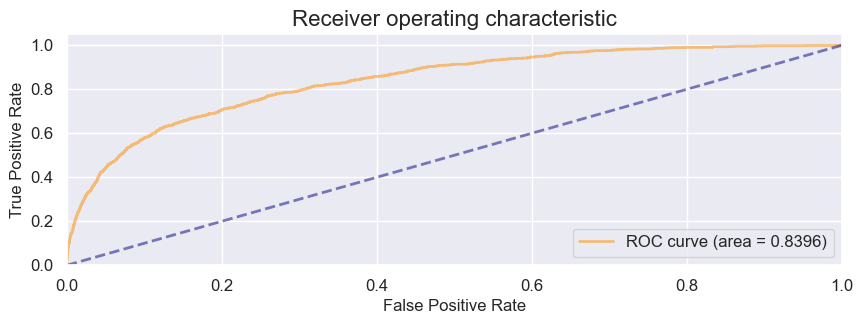

ROC-AUC: 0.8396213856596507, Gini: 0.6792427713193014
Распределение исходного таргета: 0.03127396392491581
Распределение предсказанного таргета: 0.2760644150301737


In [122]:
# Делаем предсказание на тестовых данных
y_pred_default = default_model.predict_proba(X_test_true)[:,1]

# Определяем оптимальный порог как поиск максимального значения для разницы tpr - fpr
fpr, tpr, thresholds = roc_curve(y_true=y_test_true, y_score=y_pred_default)
best_thresh = thresholds[np.argmax(tpr - fpr)]
print(f"Оптимальный порог: {best_thresh}")
# Формируем итоговое предсказание с учетом выбранного порога
y_pred_default_class = (y_pred_default > best_thresh).astype(int) 

# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test_true, y_pred=y_pred_default)
print(f"ROC-AUC: {roc_auc}, Gini: {calc_gini(roc_auc)}")

print(f"Распределение исходного таргета: {sum(y_test_true)/len(y_test_true)}")
print(f"Распределение предсказанного таргета: {sum(y_pred_default_class)/len(y_pred_default_class)}")

In [124]:
# Формируем ответный файл прогноза для тестовой выборки - "NBKI_y_test_pred.csv"
test_nbki_df["default"] = y_pred_default_class
test_nbki_df.reset_index()[["Unnamed: 0", "default"]].rename(columns={"Unnamed: 0":""}).to_csv(PATH_DATASETS + "NBKI_y_test_pred.csv", index=False)

### Отчет 
Выполнено:

1. Анализ данных
- Проведен анализ данных
- Обработаны пропуски и неверные значения
- Анализ значимости признаков. Построение матрицы корреляции
- Анализ значений близких к константе
2. Разработка моделей
- Построение базовой модели
- Проведена балансировка классов
- Выбор порога (threshold) для достижения заданных метрик
- Генерация новых признаков (не улучшило скор)
- Исключение признаков не влияющих на таргет и сильно коррелирующих между собой (не улучшило скор)